In [1]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from maskgen.vision_models.vision_maskgen import MaskGeneratingModel, convert_to_peft
from maskgen.utils import get_preprocess, collate_fn, load_imagenet
# from maskgen.utils.img_utils import plot_overlap_np
from torch.utils.data import DataLoader
import torch
import json
import os
from tqdm import tqdm
import numpy as np
from typing import Dict, Any

def load_config(config_path: str) -> Dict[str, Any]:
    """Load configuration from JSON file."""
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    # Flatten config for easier access
    flat_config = {}
    flat_config.update(config['evaluation'])
    flat_config.update(config['model'])
    flat_config.update(config['dataset'])
    
    return flat_config


In [2]:
from maskgen.utils import load_imagenet
from maskgen.utils.model_utils import get_pred_model
# Load configuration
config = load_config('eval_config.json')

# Create results directory if it doesn't exist
if not os.path.exists(config['results_path']):
    os.makedirs(config['results_path'])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Model
pretrained_name = config['pretrained_name']
processor, target_model = get_pred_model(pretrained_name, device)
vit_config = target_model.config

# Get image normalization parameters
img_mean = processor.image_mean
img_std = processor.image_std

# Target model for explanation
target_model = ViTForImageClassification.from_pretrained(pretrained_name)
target_model.eval()
target_model.to(device)

# Load trained weights
maskgen_model = MaskGeneratingModel.load_model(base_model_name=pretrained_name, 
                                save_path=config['model_path'], 
                                hidden_size=vit_config.hidden_size, 
                                num_classes=vit_config.num_labels)
maskgen_model.eval()
maskgen_model.to(device)

print() 

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/afs/crc.nd.edu/user/d/dpan/wd/maskgen-explain/maskgen/vision_models/vision_maskgen.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by th

Converted base model layers to PEFT: ['encoder.layer.0.attention.attention.query', 'encoder.layer.0.attention.attention.key', 'encoder.layer.0.attention.attention.value', 'encoder.layer.0.attention.output.dense', 'encoder.layer.0.intermediate.dense', 'encoder.layer.0.output.dense', 'encoder.layer.1.attention.attention.query', 'encoder.layer.1.attention.attention.key', 'encoder.layer.1.attention.attention.value', 'encoder.layer.1.attention.output.dense', 'encoder.layer.1.intermediate.dense', 'encoder.layer.1.output.dense', 'encoder.layer.2.attention.attention.query', 'encoder.layer.2.attention.attention.key', 'encoder.layer.2.attention.attention.value', 'encoder.layer.2.attention.output.dense', 'encoder.layer.2.intermediate.dense', 'encoder.layer.2.output.dense', 'encoder.layer.3.attention.attention.query', 'encoder.layer.3.attention.attention.key', 'encoder.layer.3.attention.attention.value', 'encoder.layer.3.attention.output.dense', 'encoder.layer.3.intermediate.dense', 'encoder.layer

Predicted class: projector


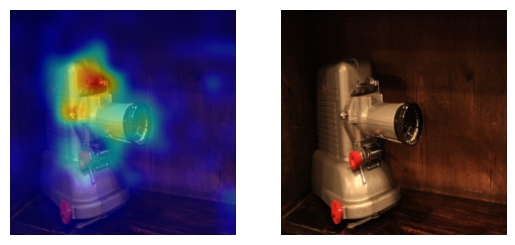

In [11]:
import requests
from PIL import Image
from maskgen.utils.img_utils import plot_overlap_np
from maskgen.utils.image_utils import get_image_example

image = get_image_example(9)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = target_model(img).logits.argmax(-1).item()
    secondary_class_idx = target_model(img).logits.argsort(descending=True)[0][1].item()

label = predicted_class_idx
# label = secondary_class_idx
label = torch.tensor([label]).to(device)

print("Predicted class:", target_model.config.id2label[label.item()])

# heatmap = torch.sigmoid(sim_logits).reshape(N, size, size)
heatmap = maskgen_model.attribute_img(img, label.unsqueeze(1), image_size=224, patch_size=16)
# heatmap = sim_logits.reshape(N, size, size)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
img_int, heatmap_img = plot_overlap_np(img, heatmap, img_mean, img_std)

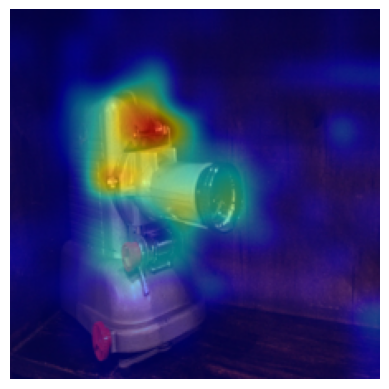

In [12]:
from maskgen.utils.img_utils import plot_overlap
plot_overlap(img_int, heatmap_img)

In [10]:
heatmap

array([[4.65720240e-03, 5.03252866e-03, 9.19103995e-03, 1.60524789e-02,
        2.24672686e-02, 1.05790747e-02, 4.46397811e-02, 2.74226367e-02,
        8.38908460e-03, 3.54177281e-02, 1.50448121e-02, 2.16249772e-03,
        6.14938885e-03, 6.20946463e-04],
       [2.36840807e-02, 4.57783975e-02, 3.57050542e-03, 2.99578737e-02,
        3.37835886e-02, 1.31033212e-02, 8.48415587e-03, 2.04334818e-02,
        1.94394067e-02, 1.35381781e-02, 2.48410623e-03, 3.72707844e-03,
        6.50595576e-02, 8.18255395e-02],
       [1.25649599e-02, 3.14735062e-02, 1.12066921e-02, 2.16668732e-02,
        9.83888581e-02, 2.98652854e-02, 6.72951341e-02, 6.80416897e-02,
        3.19468044e-02, 5.50408177e-02, 4.72812131e-02, 5.05905896e-02,
        8.84830430e-02, 5.44328839e-02],
       [2.63355915e-02, 4.42866981e-02, 3.29640065e-03, 1.34919539e-01,
        2.11445764e-01, 6.88562263e-03, 3.96830775e-02, 8.64476264e-02,
        1.38752963e-02, 2.14727484e-02, 1.07339518e-02, 2.02209372e-02,
        4.411